# Applicability of Digital Filters

Test DLF with wer201 for a wide range of frequencies, resistivities, and offsets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

from empymod import dipole, utils
utils.set_minimum(min_off=1e-30)

# Style adjustments
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True  # Comment this if you don't have LaTeX. You might have to adjust some strings.
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.style'] = 'normal'

## 1. Fullspace with skindepth

Here, we compare the digital filter with the analytical fullspace solution for a wide range of frequencies and resistivities (simple case: `aniso = 1`, `epermH = epermV = 1`, `mpermH = mpermV = 1`). 

We define the offset as a function of the skin depth $z_{skin}$, defined by

$$
z_{skin} = \left[\omega \sqrt{\frac{\mu\varepsilon}{2}}
\sqrt{\left\{1 + \left(\frac{1}{\omega\varepsilon\rho}\right\}^2 \right) -1}\right]^{-1} \, . \\
$$

In [2]:
# Define powers of frequency
fexp = np.arange(-10., 14.1, 1.)

# Define powers of resistivity
rexp = np.arange(-10, 10.1, 0.5)

# Fixed parameters
params = {'src': [0, 0, 0],
          'depth': [],
          'ht': 'fht',
          'htarg': 'wer_201_2018',
          'verb': 1}

def calc_data(fact):

    # Pre-allocate output arrays
    error = np.ones((len(fexp), len(rexp)))
    ansol = np.ones((len(fexp), len(rexp)))
    offs = np.ones((len(fexp), len(rexp)))

    # Loop over frequencies
    for i, val in enumerate(fexp):

        # Get frequency
        freq = 10**val

        # Loop over resistivities
        for ii, val2 in enumerate(rexp):

            # Get this resistivity
            res = 10**val2

            # Calculate skin depth
            omega = 2*np.pi*freq
            delta = np.sqrt(2/(mu_0*epsilon_0*omega**2))/np.sqrt(np.sqrt(1 + (1/(res*omega*epsilon_0))**2) - 1)

            # Set offset to skin_depth*fact
            off = fact*delta
            offs[i, ii] = off

            # Define this receiver
            rec = [off, 0, off/10]

            # Get analytical result (xdirect=True) and store
            an_out = dipole(rec=rec, res=res, freqtime=freq, xdirect=True, **params)
            ansol[i, ii] = np.abs(an_out)

            # Get filter result (xdirect=False), store relative error
            dlf_out = dipole(rec=rec, res=res, freqtime=freq, xdirect=False, **params)
            error[i, ii] = np.abs((dlf_out-an_out)/an_out)

    return error, ansol, offs


def plot_data(error, ansol, offs, fact):
    # Figure
    plt.figure(figsize=(10, 4))

    # Get x- and y- axis
    x = np.r_[rexp-0.25, rexp[-1]+0.25]
    y = np.r_[fexp-0.5, fexp[-1]+0.5]

    # Plot amplitude
    plt.subplot(121)
    plt.title('(a) Amplitude of analytical solution (V/m)')

    CP1 = plt.pcolormesh(x, y, np.log10(ansol), linewidth=0, rasterized=True)
    plt.colorbar(CP1)

    CS1 = plt.contour(np.log10(offs), cmap='gray', extent=[x[0], x[-1], y[0], y[-1]])
    plt.clabel(CS1, fmt='%1i', inline_spacing=25,fontsize=10)

    plt.xlabel(r'Resistivity $\log_{10}(\rho)$')
    plt.ylabel(r'Frequency $\log_{10}(f)$')
    plt.yticks(fexp[::4])
    plt.xticks(rexp[::8])

    # Plot error
    plt.subplot(122)
    plt.title('(b) Relative error ($-$)')

    CP2 = plt.pcolormesh(x, y, np.log10(error), linewidth=0, rasterized=True)
    plt.colorbar(CP2)

    CS2 = plt.contour(np.log10(offs), cmap='gray', extent=[x[0], x[-1], y[0], y[-1]])
    plt.clabel(CS2, fmt='%1i', inline_spacing=25,fontsize=10)

    plt.xlabel(r'Resistivity $\log_{10}(\rho)$')
    plt.ylabel(r'Frequency $\log_{10}(f)$')
    plt.yticks(fexp[::4])
    plt.xticks(rexp[::8])

    # Save figure
    plt.savefig('../figures/skindepth'+str(fact)+'.pdf', bbox_inches='tight')
    
    # Title
    title = 'Horizontal offset = '+str(fact)+'$*z_{skin}$; vertical src-rec separation = '+str(fact/10)+'$*z_{skin}$.'
    plt.suptitle(title, y=1.01)

    plt.show()

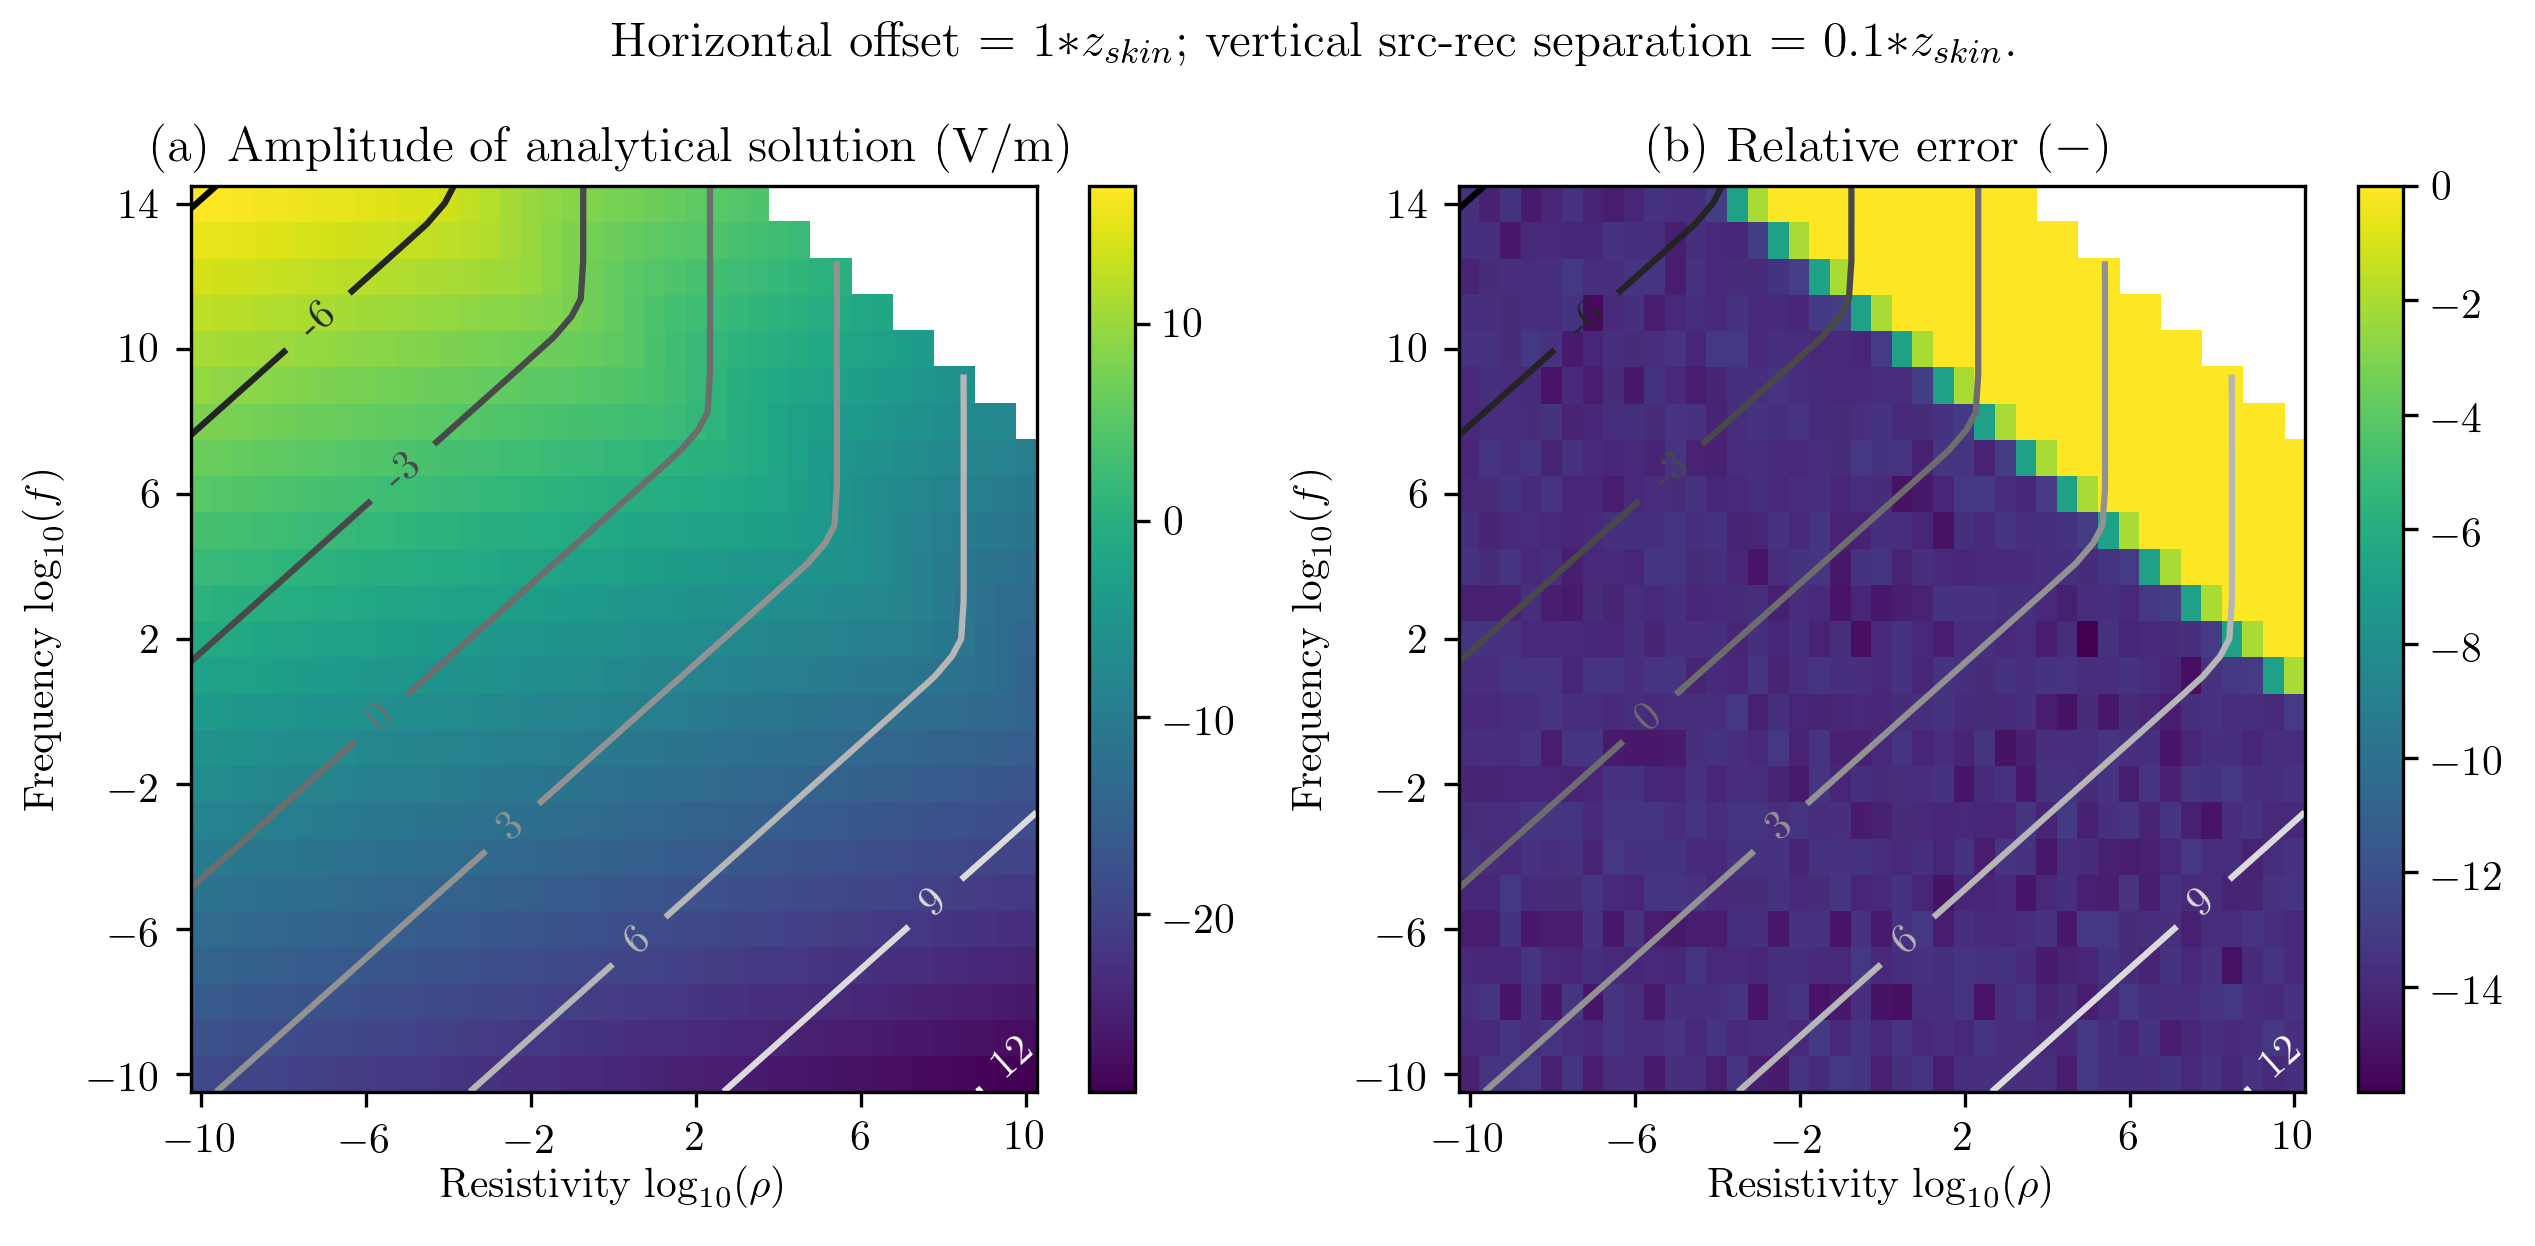

In [3]:
fact = 1
error, ansol, offs = calc_data(fact)
plot_data(error, ansol, offs, fact)

## 2. Deep water, shallow water, and land case

### Generate data

In [4]:
# Offsets from 50 m to 20 km, logarithmically
x = np.logspace(np.log10(50/200), 2, 50)*200

# Frequencies from 0.01 Hz to 10 Hz, logarithmically
freqs = np.logspace(-2, 1, 50)

# Resistivities of lower half-space
res = [1, 10, 100, 1000]

# Source and receiver depths for the three cases
zsrc = [10, 1990, 0.5]
zrec = [100, 2000, 0.8]

# Water depths and resistivity for deep/shallow cases
wdepth = [400, 2000]
wres = 0.3

# General input parameters
inp = {'ab': 11, 'freqtime': freqs, 'verb': 1,}  

# Pre-allocate arrays for all three models, 4 resistivities
amp = np.zeros((3, len(freqs), len(x), 4))
err = np.zeros((3, len(freqs), len(x), 4))

# Loop over the three cases
for i, name in enumerate(['deep', 'shallow', 'land']):
    
    # Update model
    inp['src'] = [0, 0, zrec[i]]
    inp['rec'] = [x, x*0, zsrc[i]]
    if i < 2:
        inp['depth'] = [0, wdepth[i]]
        inp['res'] = [2e14, wres, -1]  # -1: we'll update later
    else:
        inp['depth'] = [0]
        inp['res'] = [2e14, -1]  # -1: we'll update later

    # Loop over 4 lower halfspace resistivities
    for ii, ires in enumerate(res):

        # Update lower halfspace resistivity
        inp['res'][-1] = ires

        # Calculate responses
        wer201 = dipole(htarg='wer_201_2018', **inp)
        qwe = dipole(ht='qwe', **inp)

        # Calculate relative error
        error = np.abs((wer201-qwe)/qwe)

        # Store analytical amplitude and relative error
        amp[i, :, :, ii] = np.abs(qwe)
        err[i, :, :, ii] = error

* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.
* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.
* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.


### Plot relative error

In [5]:
# pcolor needs start and endpoints, not actual points (midpoints)
xdif = (np.log10(x[1])-np.log10(x[0]))/2
xax = np.r_[np.log10(x/1000)-xdif, np.log10(x[-1]/1000)+xdif]
fdif = (np.log10(freqs[1])-np.log10(freqs[0]))/2
fax = np.r_[np.log10(freqs)-fdif, np.log10(freqs[-1])+fdif]

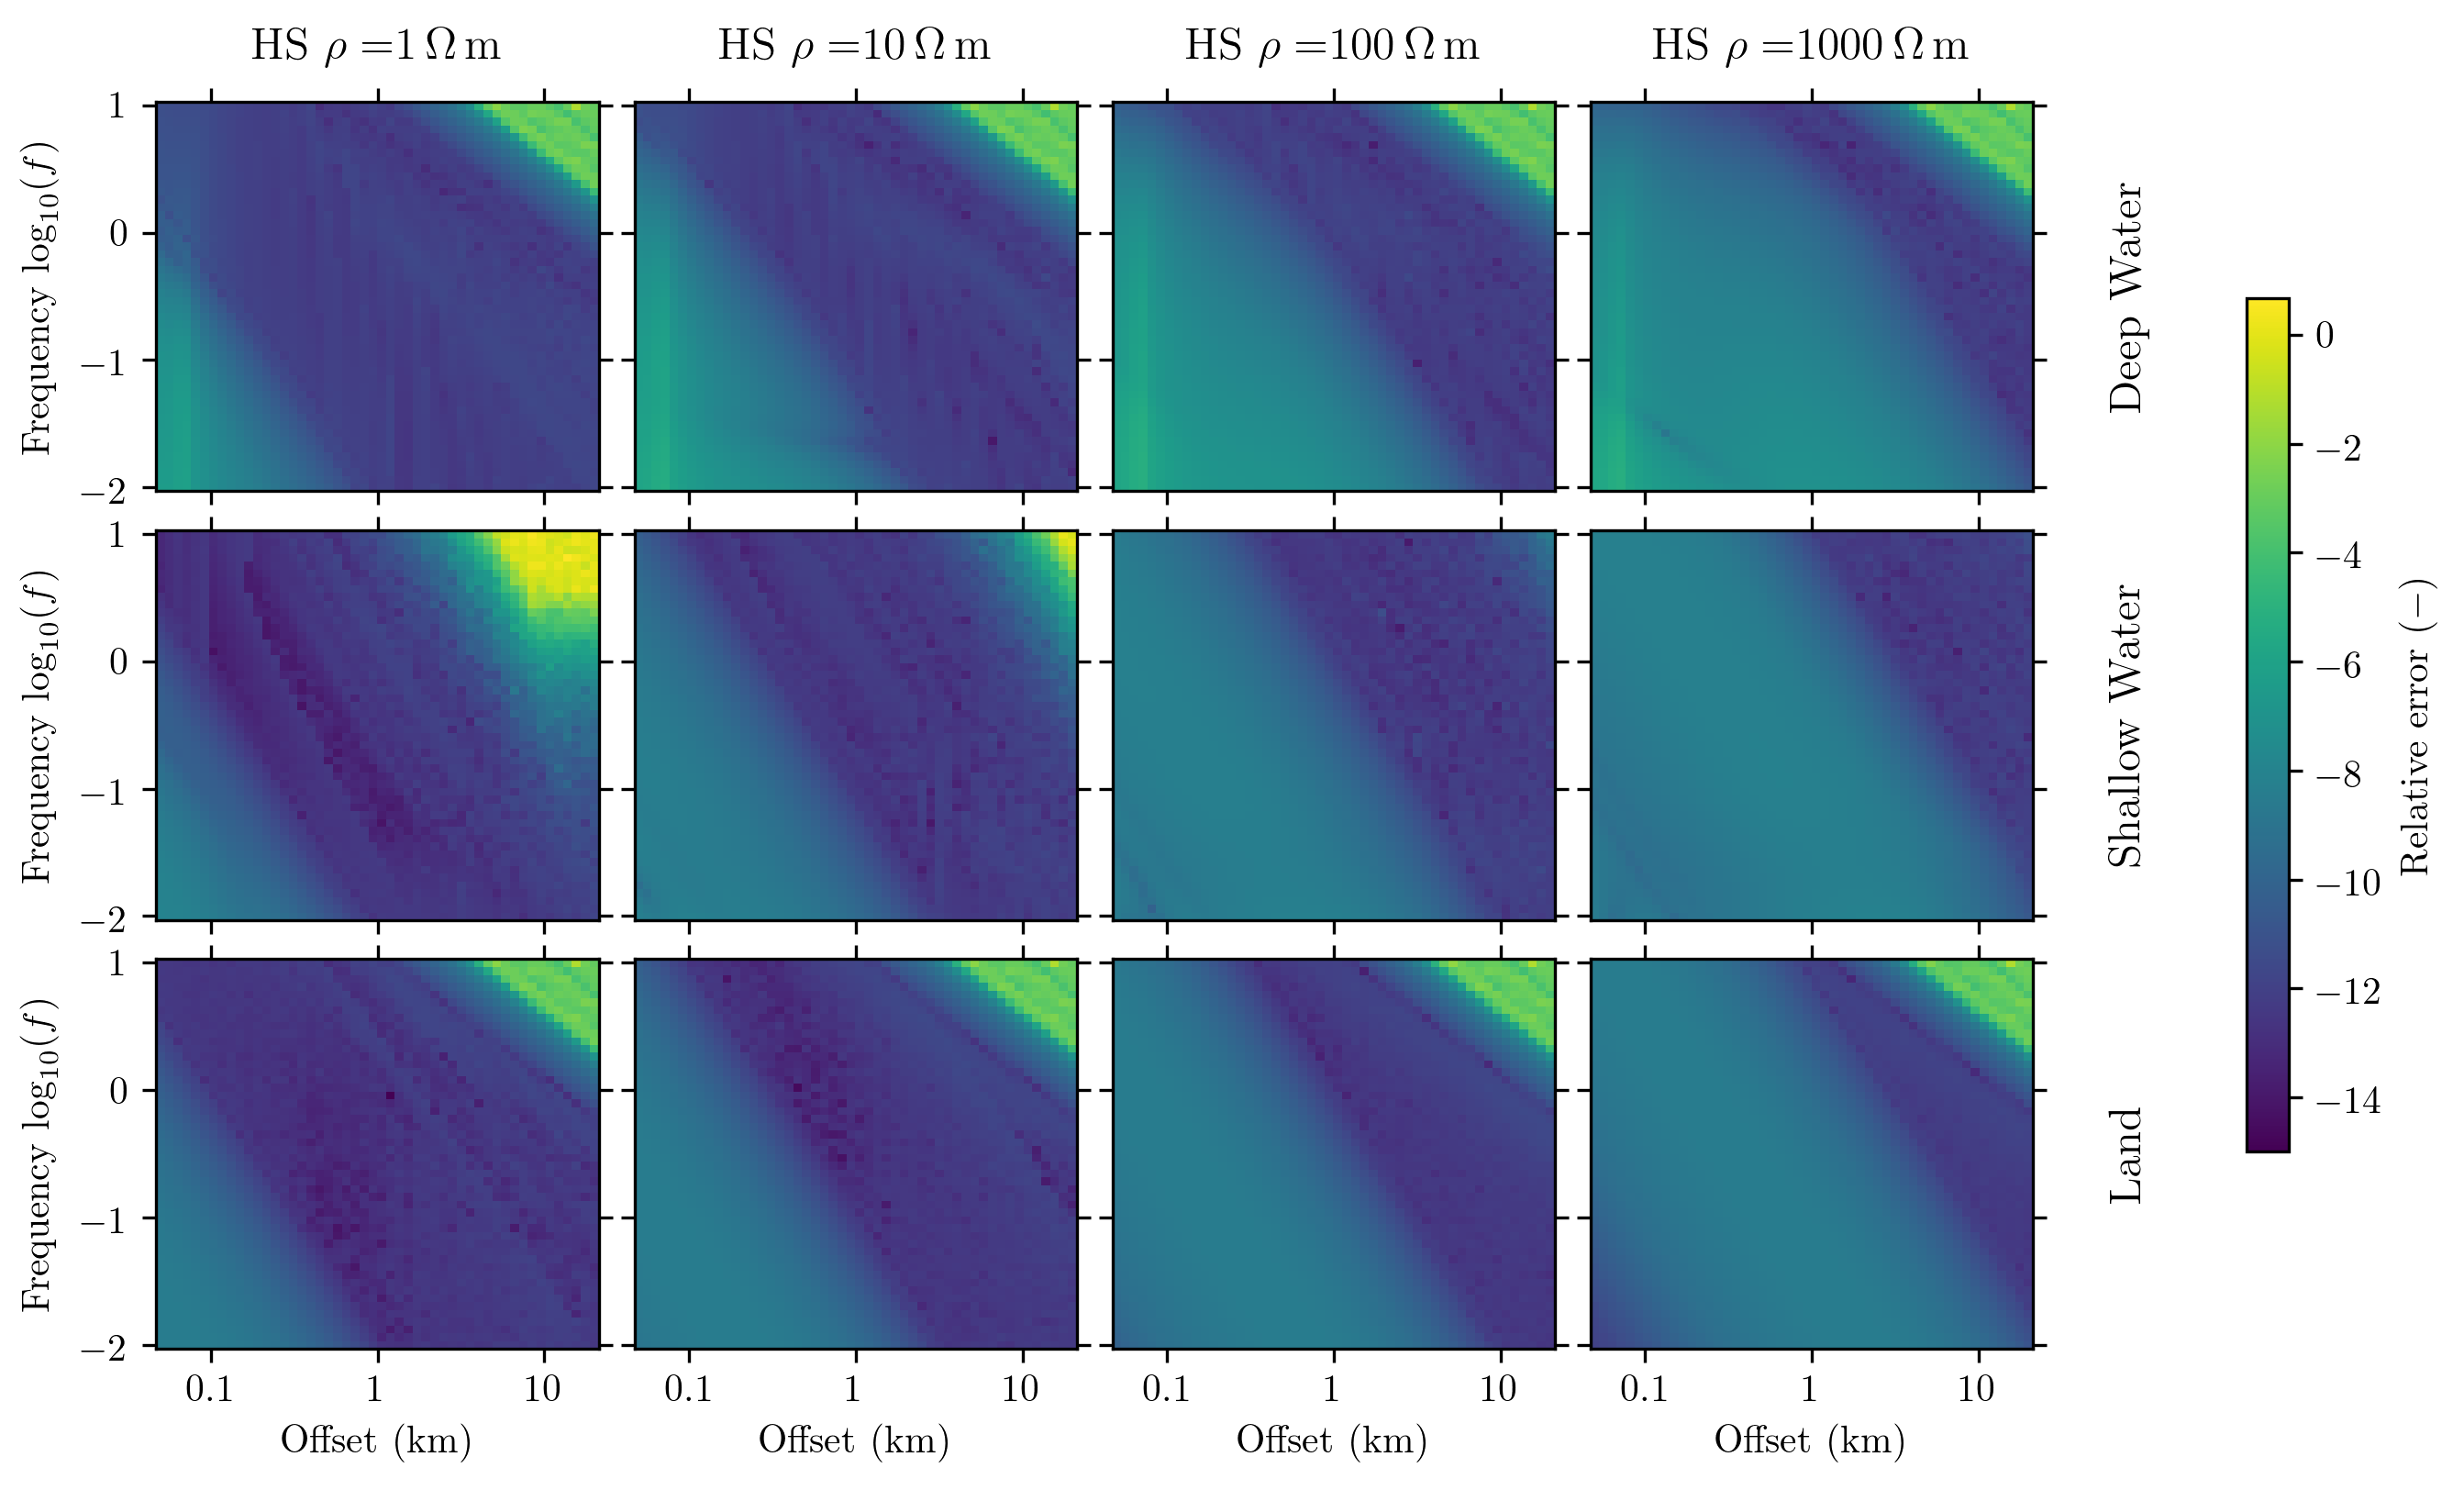

In [6]:
# Get min and max    
vmin = np.min(np.log10(err))
vmax = np.max(np.log10(err))

# General parameters
params = {'vmin': vmin, 'vmax': vmax,# 'cmap': 'Greys',
          'linewidth': 0, 'rasterized': True}

# Start figure
fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=4, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.08, hspace=0.1)
axs = axs.ravel()
cplist = []

# Loop over cases
for i, name in enumerate(['Deep Water', 'Shallow Water', 'Land']):

    # Loop over resistivities
    for ii, ires in enumerate(res):
        plt.sca(axs[i*4+ii])
        
        # Plot result, store handle
        cp = plt.pcolormesh(xax, fax, np.log10(err[i, :, :, ii]), **params)
        cplist.append(cp)
        
        # Show ticks on all four sides
        axs[i*4+ii].xaxis.set_ticks_position('both')
        axs[i*4+ii].yaxis.set_ticks_position('both')
            
        # title
        if i == 0:
            plt.title(r'HS $\rho = $'+str(ires)+r'$\,\Omega\,$m', fontsize=12, y=1.05)
                
        # x-ticks and labels
        if i == 2:
            plt.xticks([-1, 0, 1], ['0.1', '1', '10'])
            plt.xlabel(r'Offset (km)')
        else:
            plt.xticks()

        # y-label
        if ii == 0:
            plt.ylabel(r'Frequency $\log_{10}(f)$')
        elif ii == 3:
            axs[i*4+ii].yaxis.set_label_position("right")
            plt.ylabel(name, fontsize=12, labelpad=20)

# Colorbar
cax, kw = plt.matplotlib.colorbar.make_axes(axs,# location='bottom',
                                            fraction=.02, pad=0.1, aspect=20)
cb = plt.colorbar(cplist[(i+1)*4-1], cax=cax, **kw)
cb.set_label('Relative error ($-$)')#, labelpad=-40, y=1.05, rotation=0)

# Save figure
plt.savefig('../figures/error.pdf', bbox_inches='tight')

# Title
# plt.suptitle('Relative error ($-$)', fontsize=14, y=0.97)

plt.show()

### Plot QWE amplitude

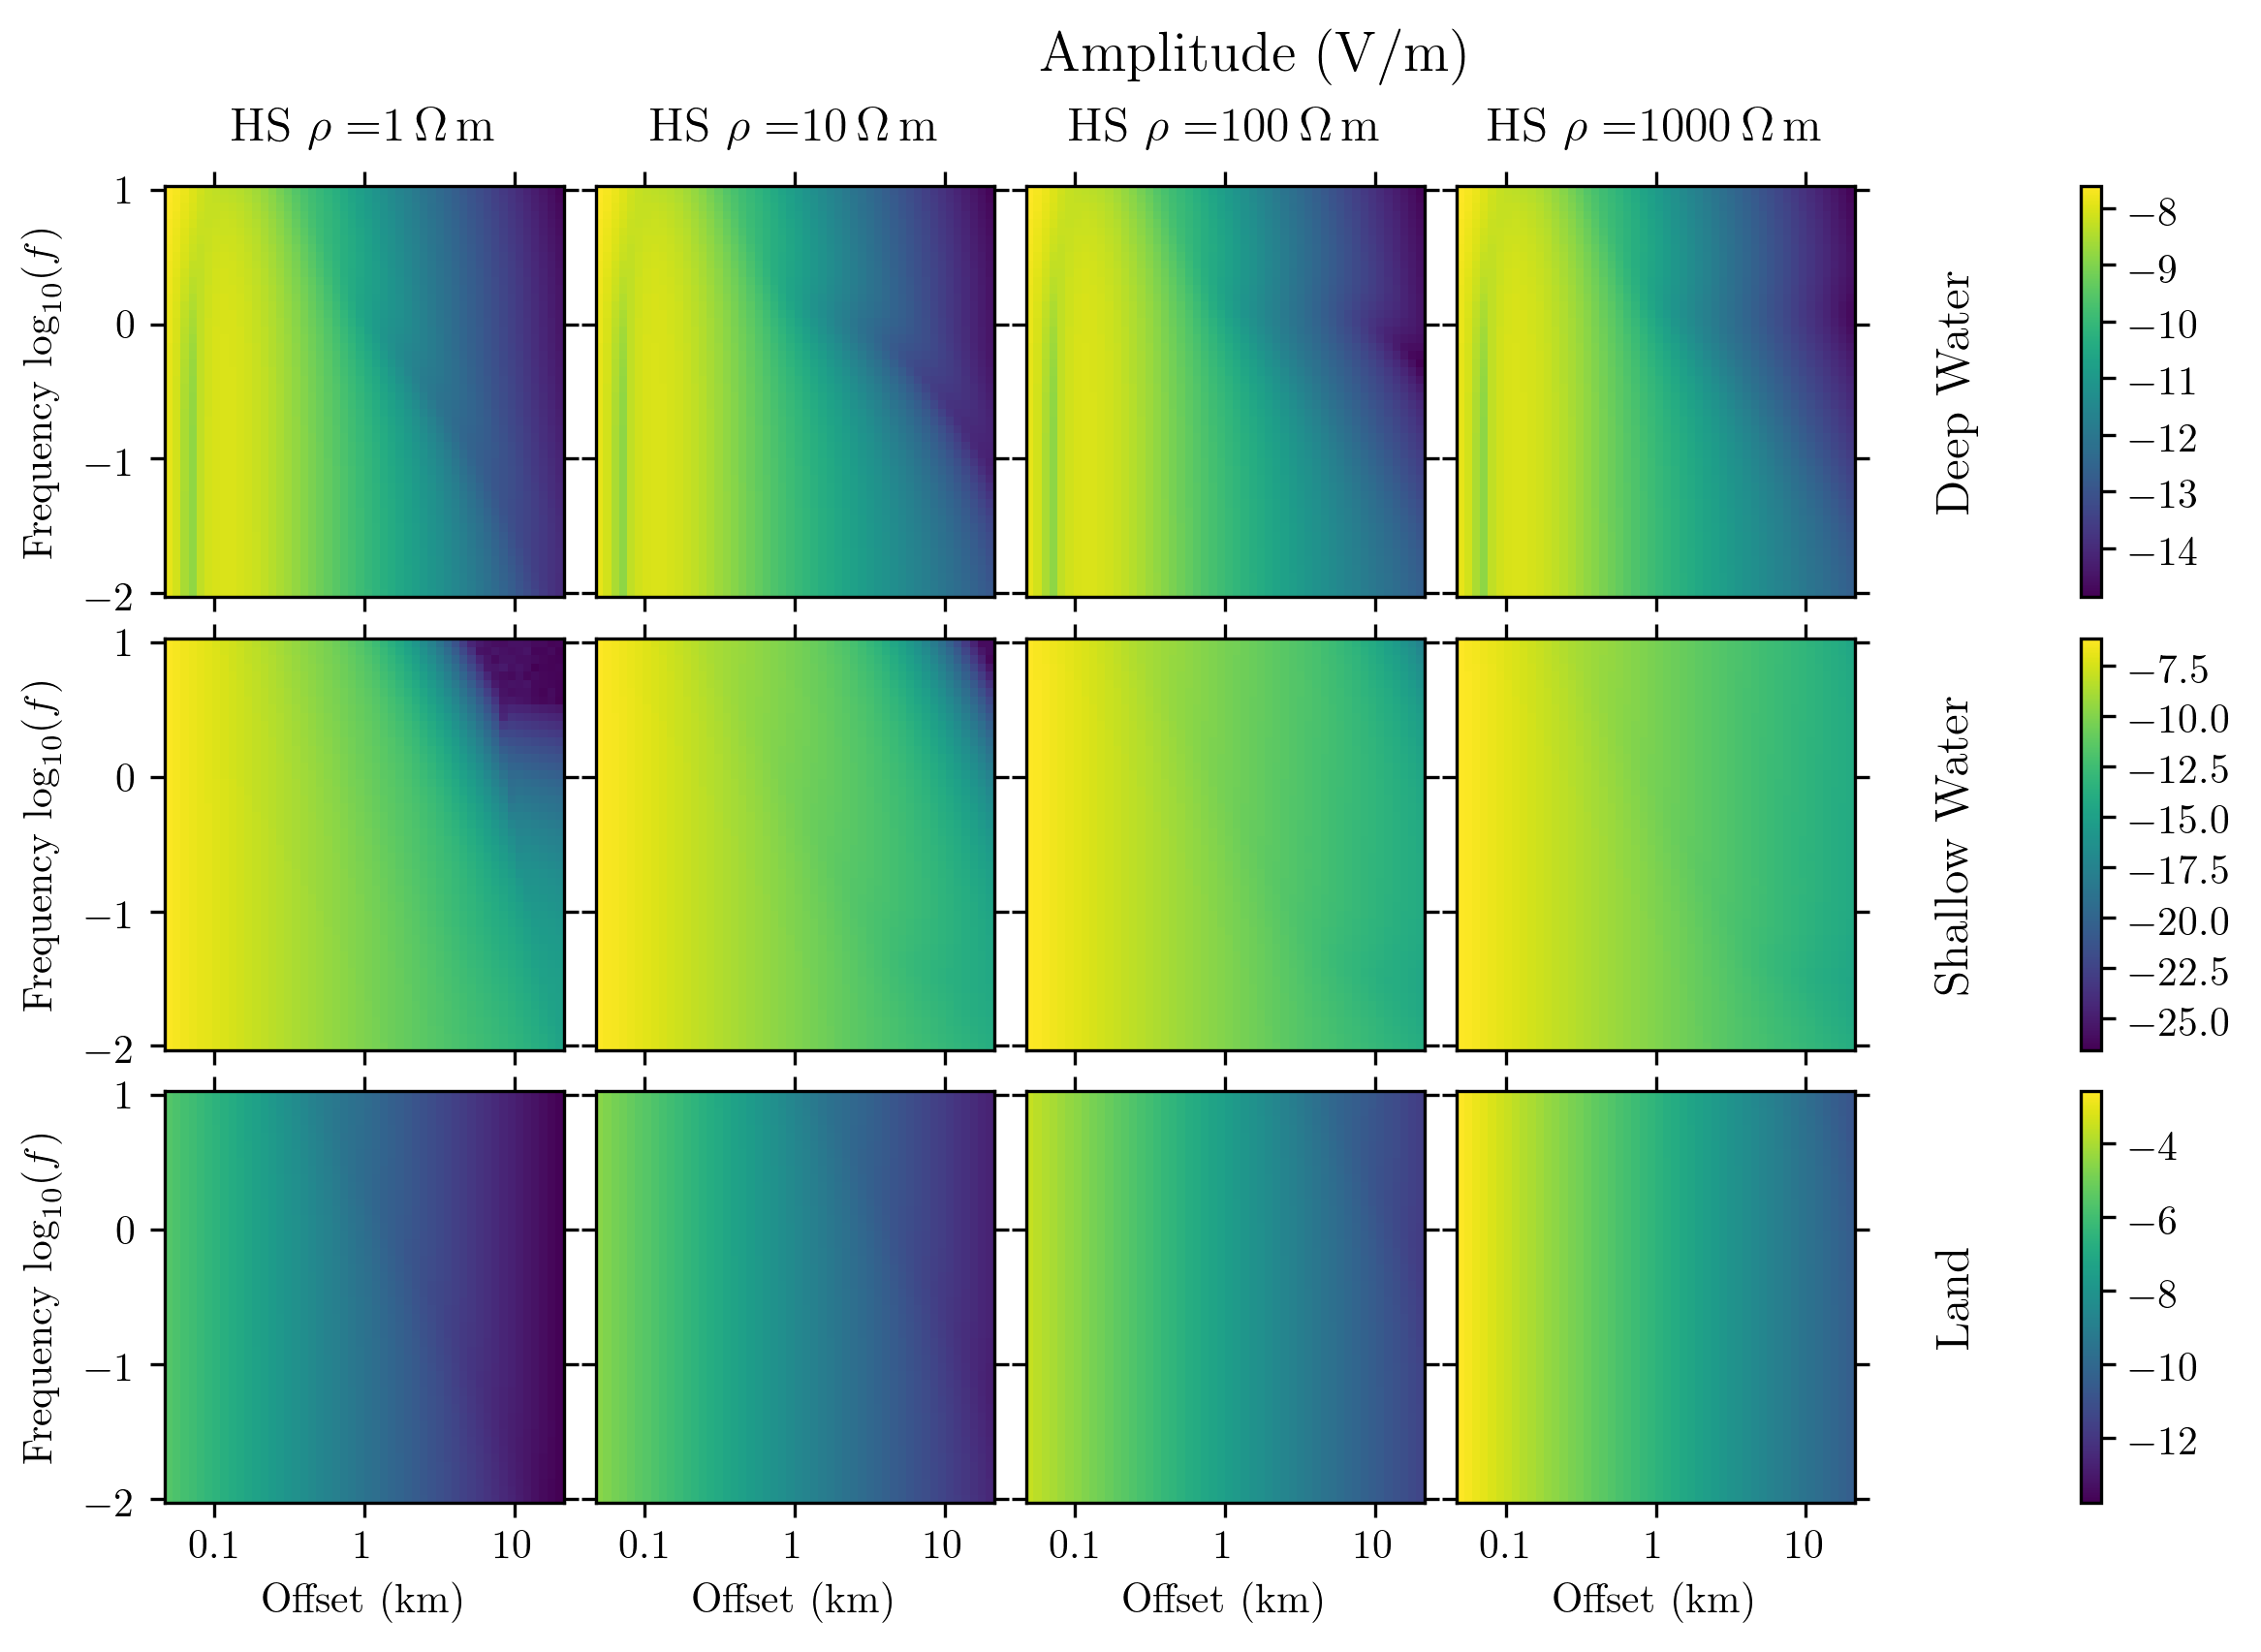

In [7]:
# Start figure
fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=4, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.08, hspace=0.1)
axs = axs.ravel()
cplist = []

# Loop over cases
for i, name in enumerate(['Deep Water', 'Shallow Water', 'Land']):

    # Get min and max    
    vmin = np.min(np.log10(amp[i, :, :, :]))
    vmax = np.max(np.log10(amp[i, :, :, :]))

    # General parameters
    params = {'vmin': vmin, 'vmax': vmax,# 'cmap': 'Greys',
              'linewidth': 0, 'rasterized': True}

    # Loop over resistivities
    for ii, ires in enumerate(res):
        plt.sca(axs[i*4+ii])
        
        # Plot result, store handle
        cp = plt.pcolormesh(xax, fax, np.log10(amp[i, :, :, ii]), **params)
        cplist.append(cp)
        
        # Show ticks on all four sides
        axs[i*4+ii].xaxis.set_ticks_position('both')
        axs[i*4+ii].yaxis.set_ticks_position('both')
            
        # title
        if i == 0:
            plt.title(r'HS $\rho = $'+str(ires)+r'$\,\Omega\,$m', fontsize=12, y=1.05)
                
        # x-ticks and labels
        if i == 2:
            plt.xticks([-1, 0, 1], ['0.1', '1', '10'])
            plt.xlabel(r'Offset (km)')
        else:
            plt.xticks()

        # y-label
        if ii == 0:
            plt.ylabel(r'Frequency $\log_{10}(f)$')
        elif ii == 3:
            axs[i*4+ii].yaxis.set_label_position("right")
            plt.ylabel(name, fontsize=12, labelpad=20)

    # Colorbar
    cax, kw = plt.matplotlib.colorbar.make_axes(axs[i*4:(i+1)*4], pad=0.1)#fraction=.05, aspect=30)
    cb = plt.colorbar(cplist[(i+1)*4-1], cax=cax, **kw)

# Save figure
# plt.savefig('../figures/amplitude.pdf', bbox_inches='tight')

# Title
plt.suptitle('Amplitude (V/m)', fontsize=14, y=0.97)

plt.show()

In [8]:
import printinfo
printinfo.info()